In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def dataloader(batch_size=64, validation_split=0.2, shuffle_buffer_size=10000):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

    # Create training and validation datasets
    num_train_samples = int((1 - validation_split) * len(X_train))
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train[:num_train_samples], y_train[:num_train_samples]))
    validation_dataset = tf.data.Dataset.from_tensor_slices((X_train[num_train_samples:], y_train[num_train_samples:]))
    train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer_size).batch(batch_size)
    validation_dataset = validation_dataset.batch(batch_size)

    # Create test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, validation_dataset, test_dataset

In [3]:
def show_images(images, labels, num_images=25, row=5, col=5):
    fig, axes = plt.subplots(row, col, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
train_dataset, validation_dataset, test_dataset = dataloader(batch_size=64, validation_split=0.2, shuffle_buffer_size=10000)

In [5]:
len(train_dataset)

750

In [6]:
len(validation_dataset)

188

In [7]:
len(test_dataset)

157

In [8]:
batch = next(iter(train_dataset))
images, labels = batch[0].numpy(), batch[1].numpy()

In [9]:
images.shape

(64, 28, 28, 1)

In [10]:
images[0].shape

(28, 28, 1)

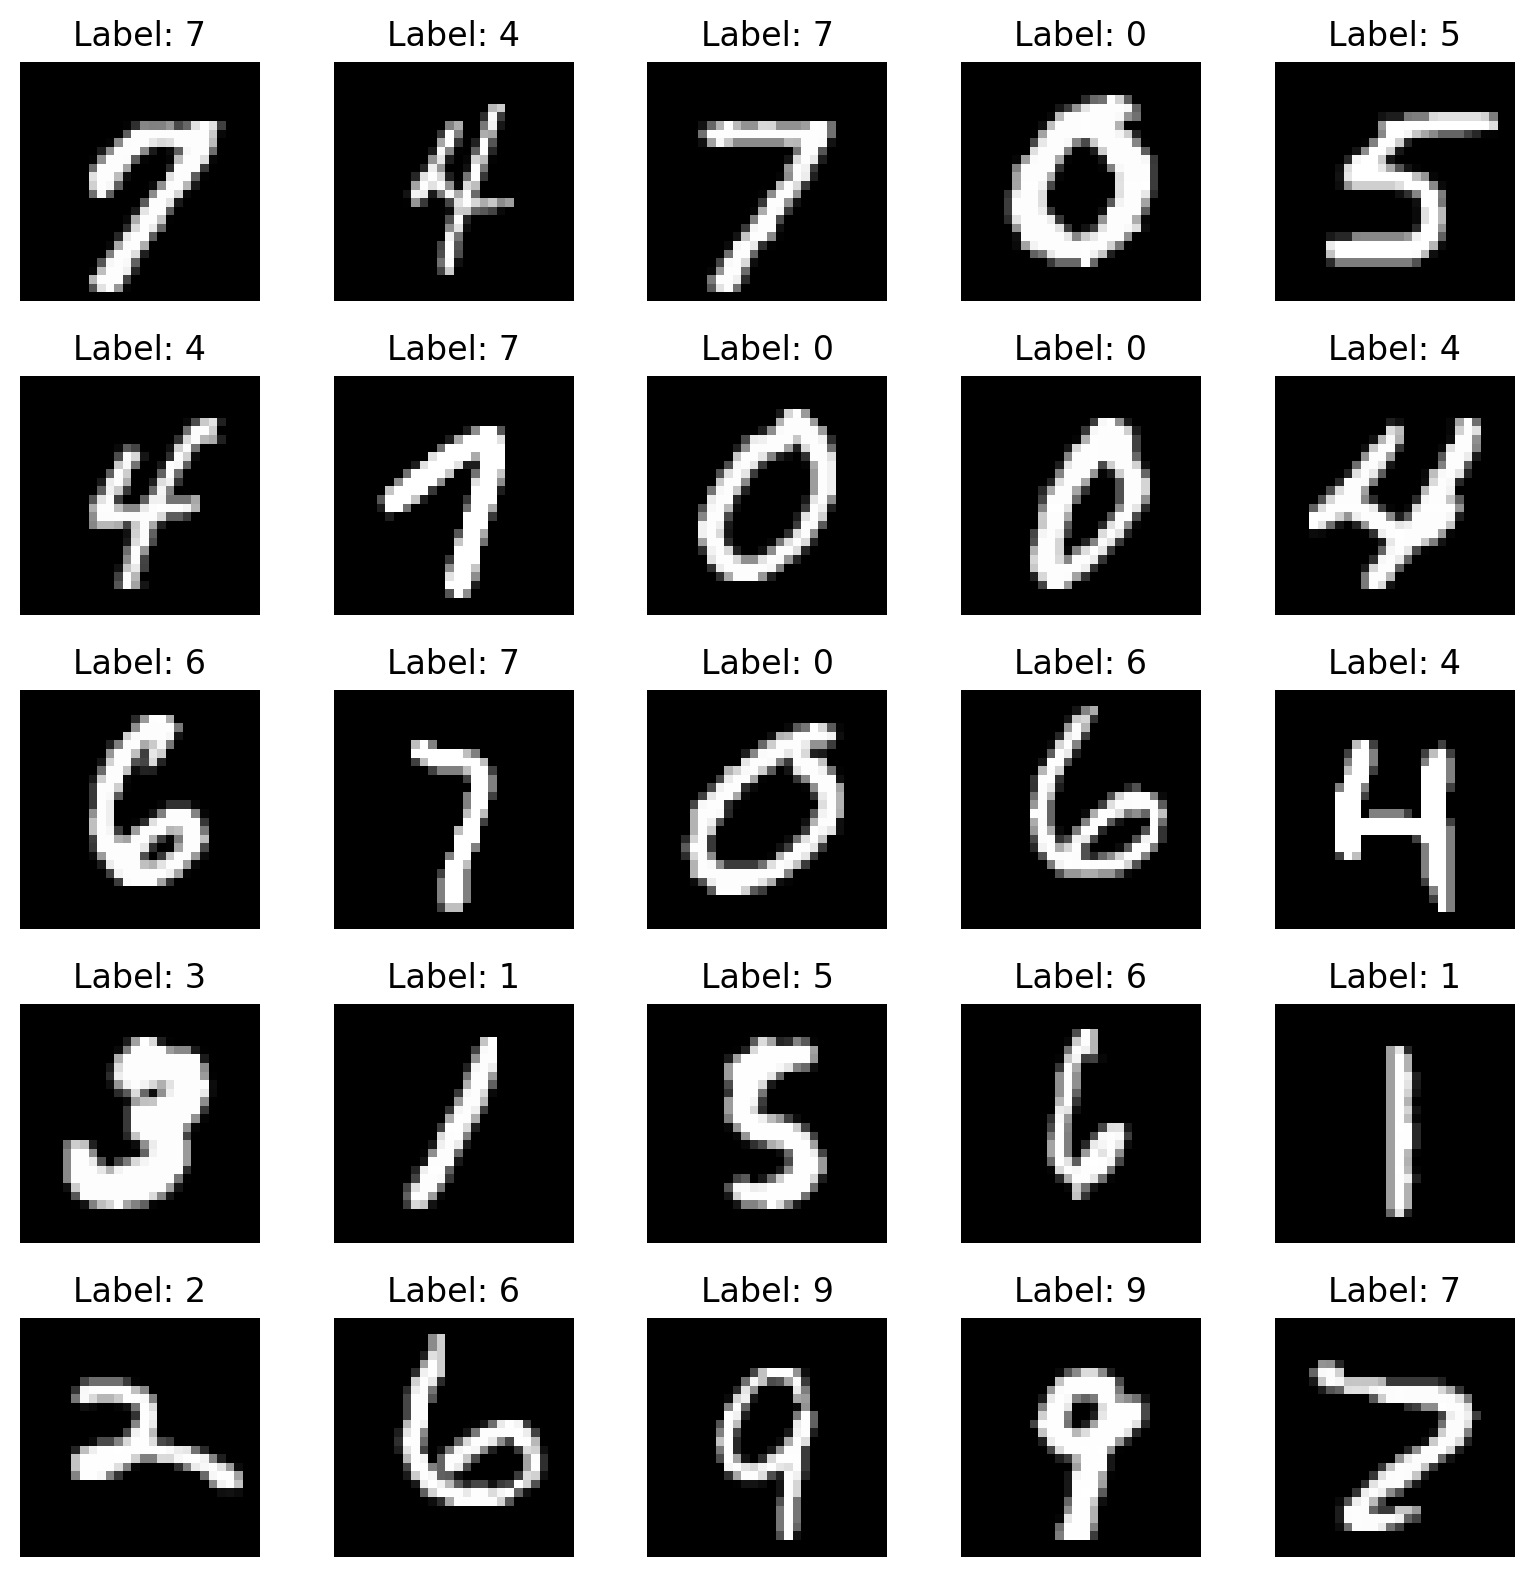

In [11]:
show_images(images, labels, num_images=25, row=5, col=5)

In [12]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = images[0].shape

In [13]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS

(28, 28, 1)

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
));
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

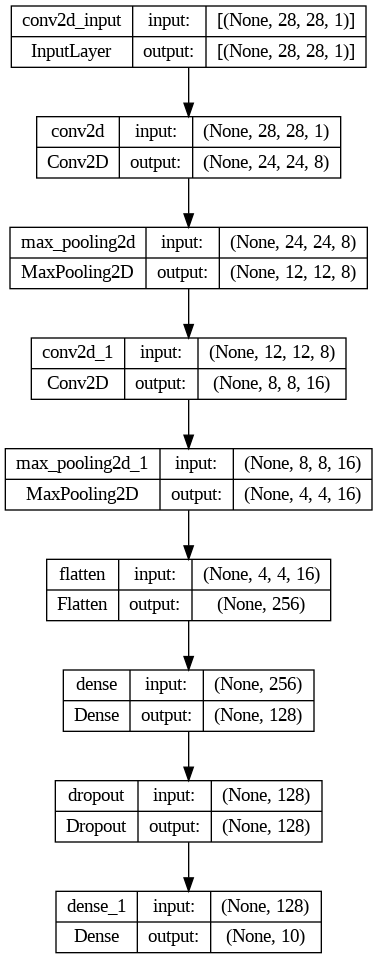

In [16]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [18]:
# Fit the model
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=validation_dataset)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/3
750/750 [==============================] - 56s 70ms/step - loss: 0.2881 - accuracy: 0.9114 - val_loss: 0.1064 - val_accuracy: 0.9678
Epoch 2/3
750/750 [==============================] - 35s 46ms/step - loss: 0.0945 - accuracy: 0.9707 - val_loss: 0.0685 - val_accuracy: 0.9790
Epoch 3/3
157/157 [==============================] - 1s 9ms/step - loss: 0.0493 - accuracy: 0.9836
Test Loss: 0.04926199093461037
Test Accuracy: 0.9836000204086304


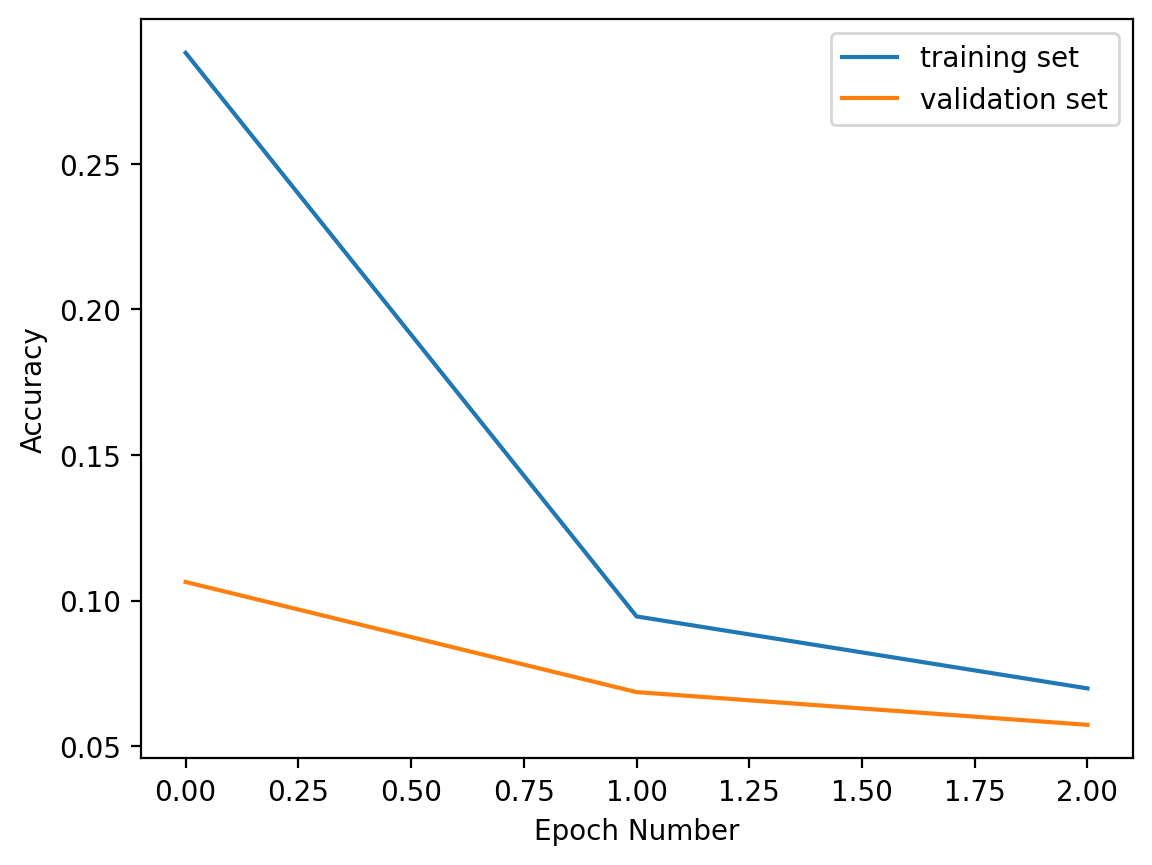

In [19]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.legend()

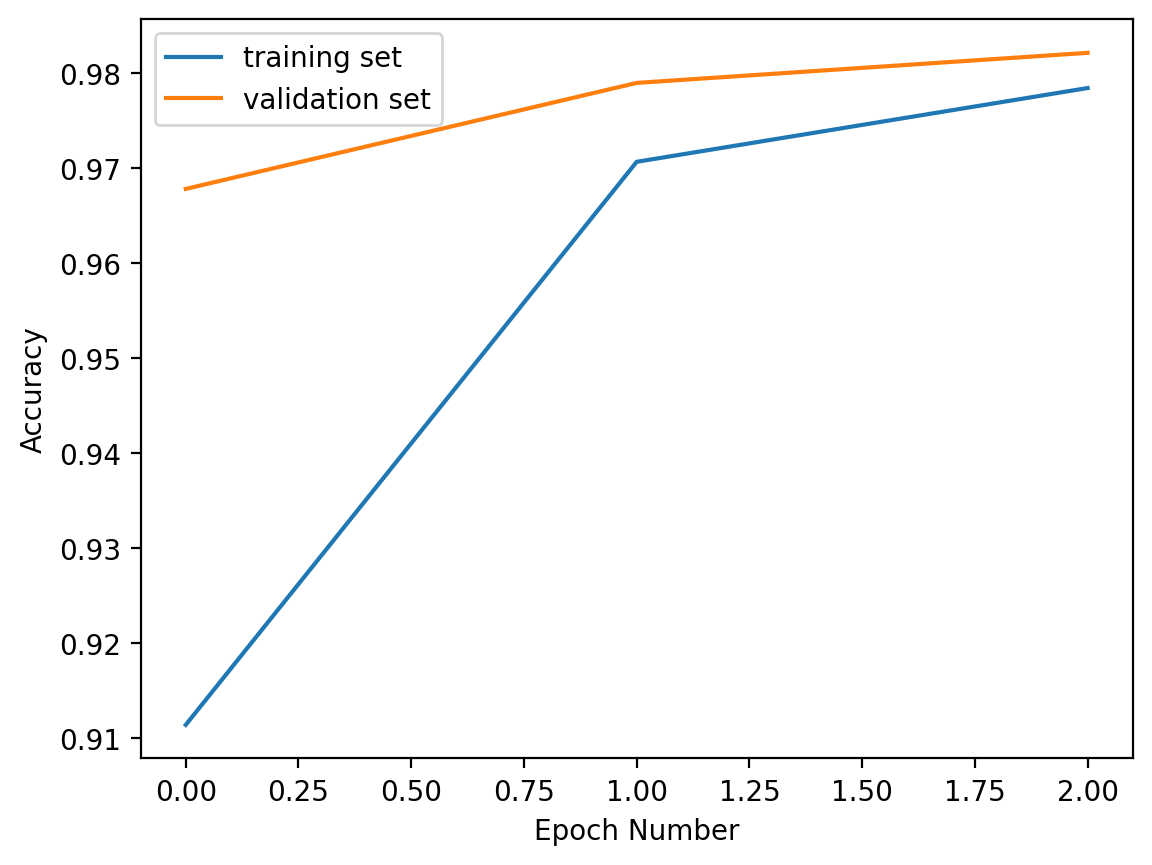

In [20]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
plt.legend()


In [22]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

for images, labels in train_dataset:
    predictions = model(images, training=False)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    train_loss(loss)
    train_accuracy(labels, predictions)

print('Train loss: ', train_loss.result().numpy())
print('Train accuracy: ', train_accuracy.result().numpy())

Train loss:  0.043830525
Train accuracy:  0.9863333


In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

for images, labels in validation_dataset:
    predictions = model(images, training=False)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    train_loss(loss)
    train_accuracy(labels, predictions)

print('Train loss: ', train_loss.result().numpy())
print('Train accuracy: ', train_accuracy.result().numpy())

Train loss:  0.057293512
Train accuracy:  0.98216665


In [24]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')
loaded_model = tf.keras.models.load_model(model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import matplotlib.pyplot as plt

def save_images(test_dataset, num_images=25):
    predictions_one_hot = loaded_model.predict(test_dataset)
    predictions = np.argmax(predictions_one_hot, axis=1)

    images = []
    labels = []
    for image, label in test_dataset.take(num_images):
        for i in range(image.shape[0]):
            images.append(image[i].numpy().squeeze())
            labels.append(label[i].numpy())
    return images, labels

In [40]:
images, labels = save_images(test_dataset, num_images=25)

157/157 [==============================] - 1s 9ms/step


In [41]:
def show_images(images, labels, num_images=25, row=5, col=5):
    fig, axes = plt.subplots(row, col, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

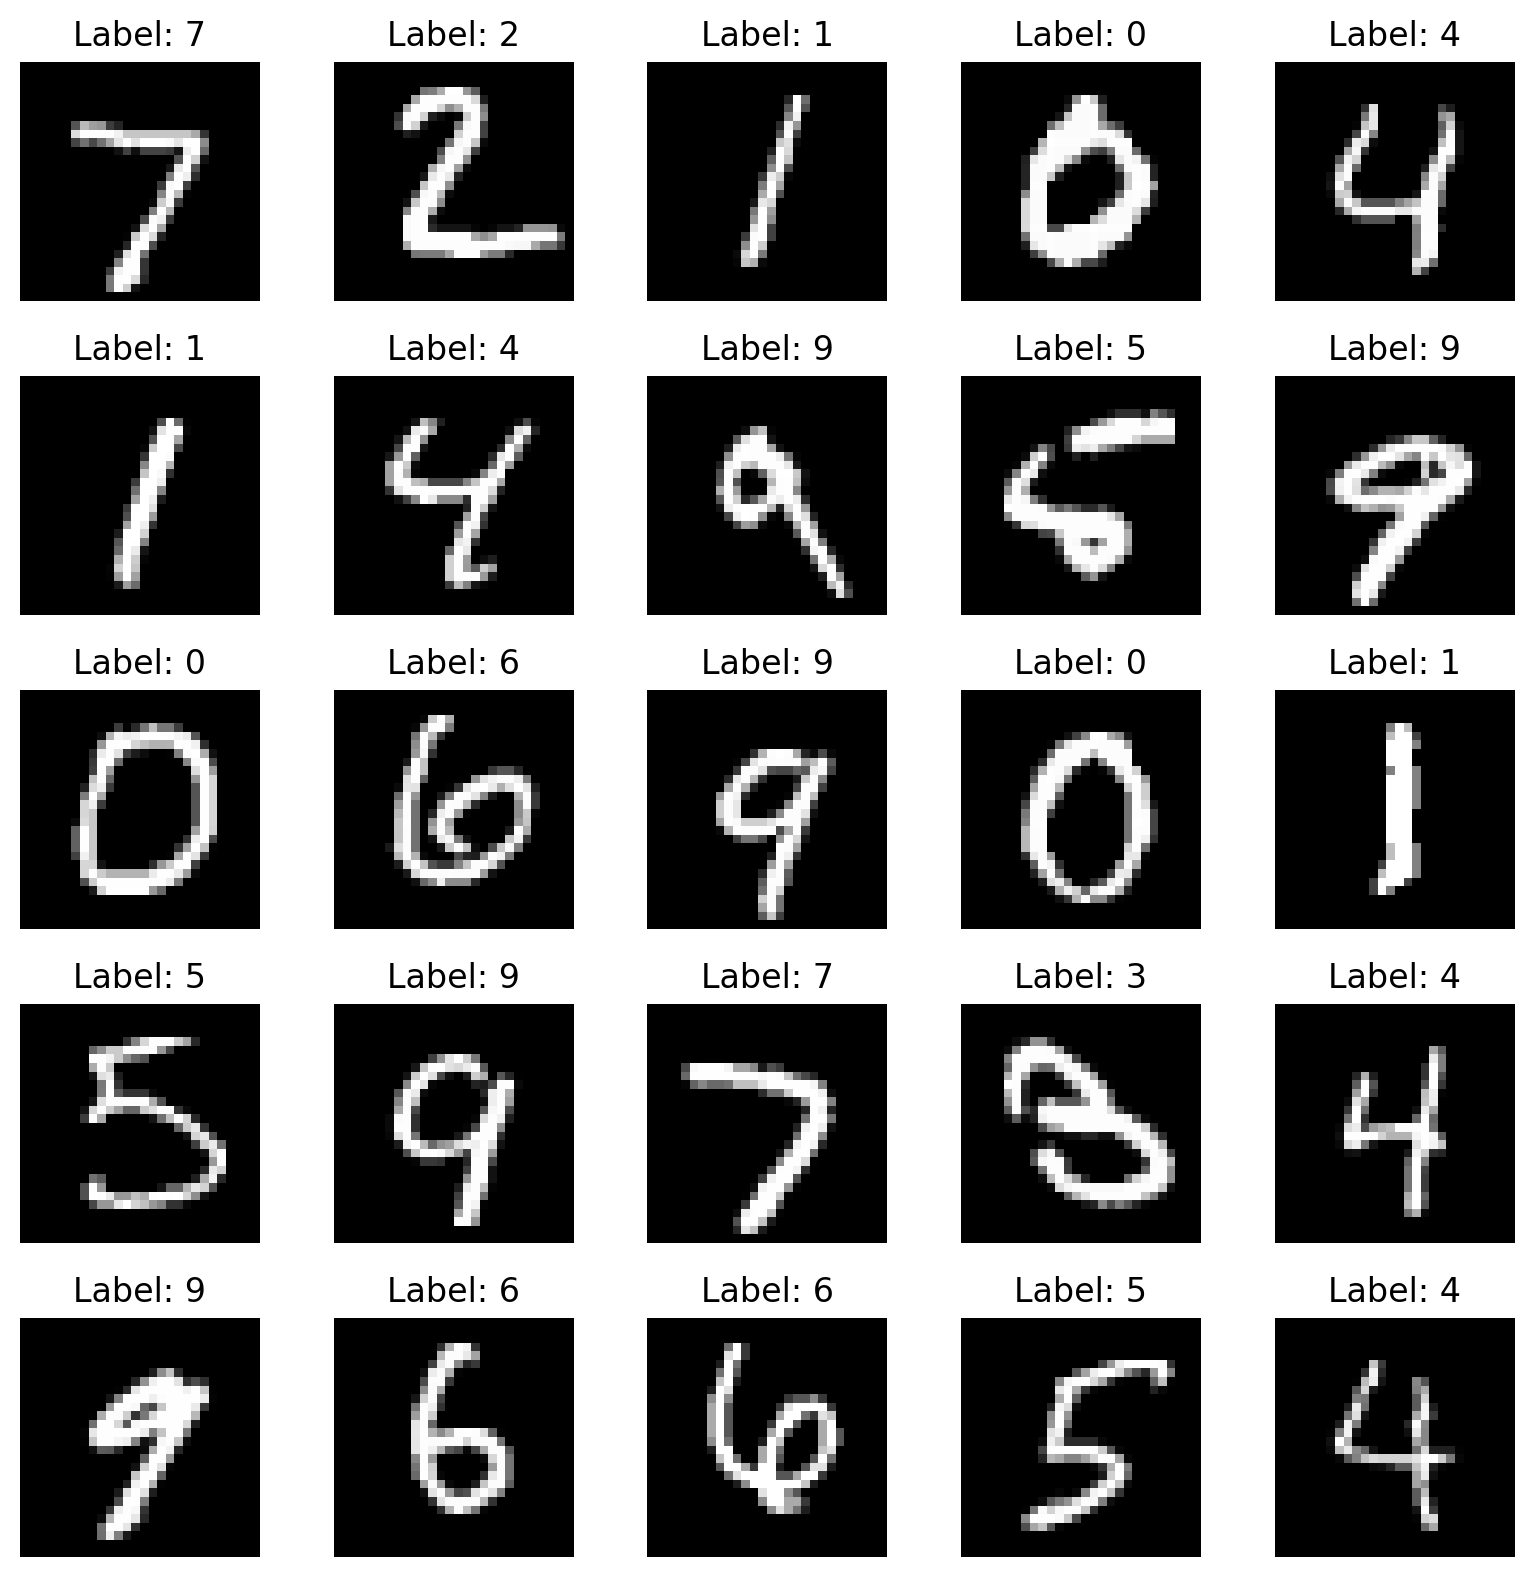

In [42]:
show_images(images, labels, num_images=25, row=5, col=5)

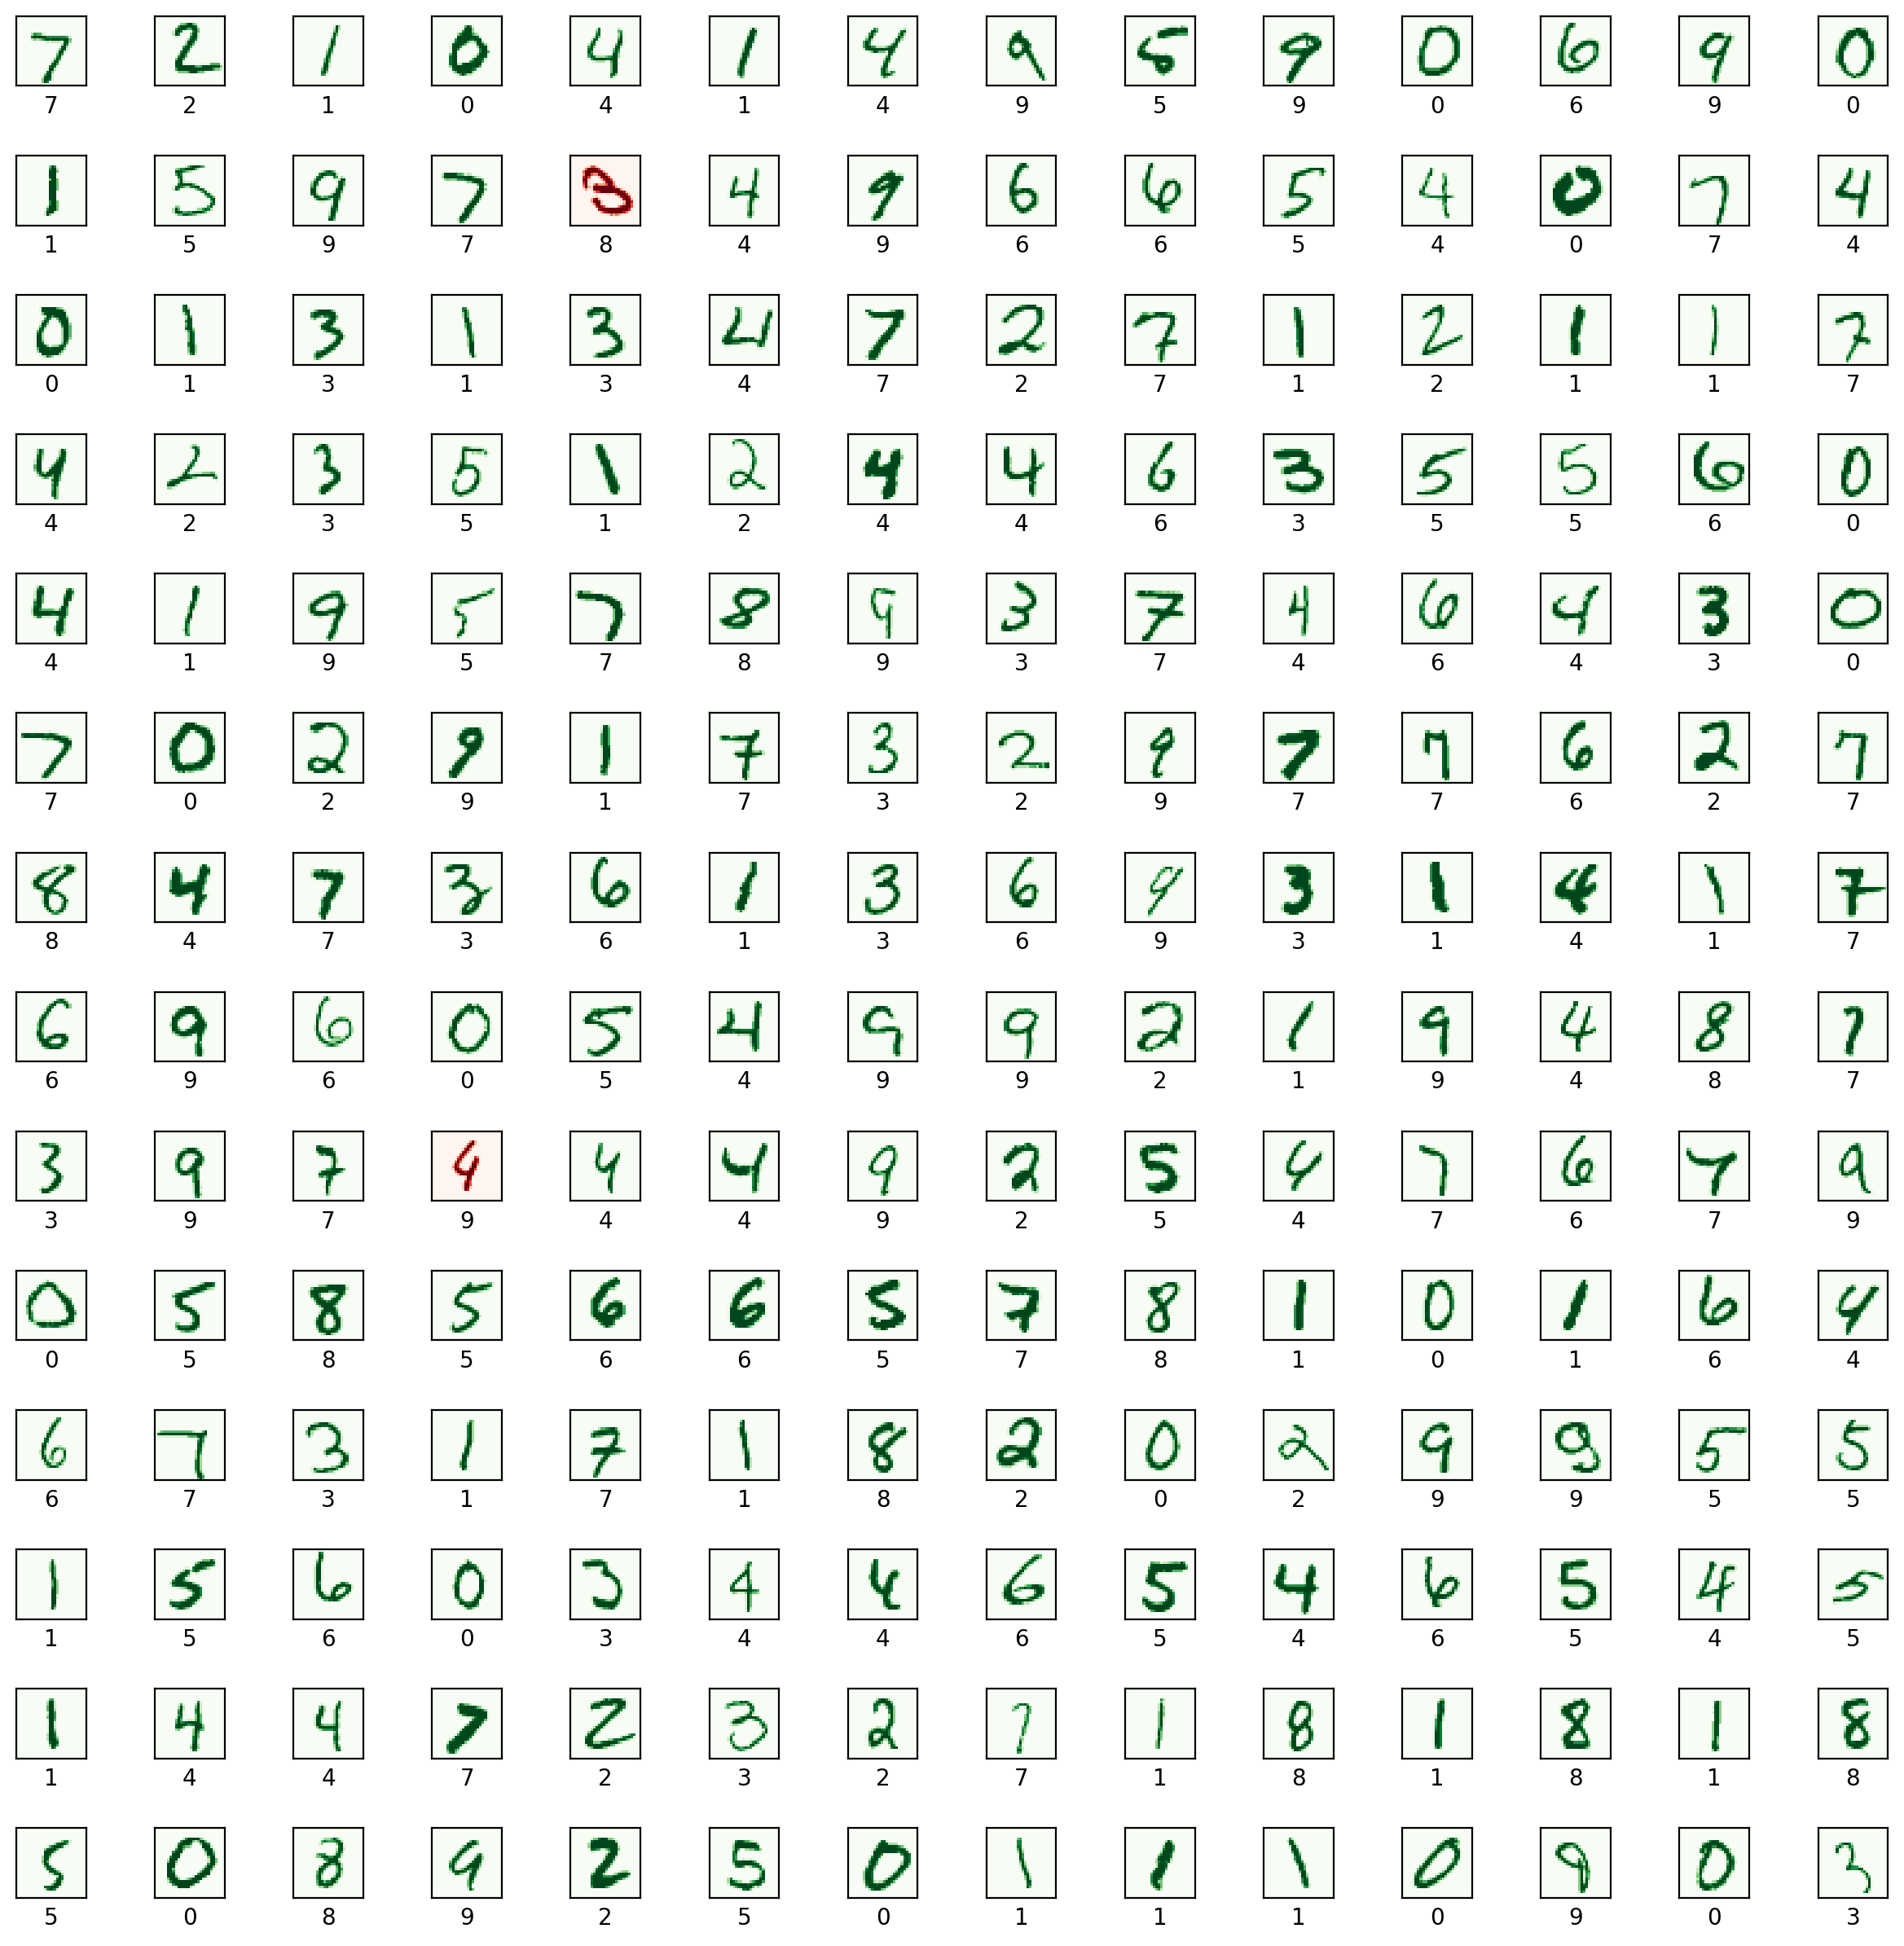

In [43]:
import math
import matplotlib.pyplot as plt

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))
for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == labels[plot_index] else 'Reds'
    plt.imshow(images[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()